In [42]:
import os

import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

import src.visualization as vs
import src.json_cleaning as jc


In [32]:
data = pd.read_csv('data/raw/kickstarter.csv')

In [33]:
# dropping columns
drop_these = [
    'converted_pledged_amount',
    'currency',
    'currency_symbol',
    'currency_trailing_code',
    'current_currency',
    'disable_communication',
    'friends',
    'fx_rate',
    'id',
    'is_backing',
    'is_starrable',
    'is_starred',
    'permissions',
    'pledged',
    'slug',
    'source_url',
    'spotlight',
    'state_changed_at',
    'urls',
    'usd_type']

drop_these_too = [
    'creator',
    'location',
    'photo',
    'profile',
]

data.drop(drop_these, axis=1, inplace=True)
data.drop(drop_these_too, axis=1, inplace=True)

In [34]:
# convert goal with static_usd_rate, drop both afterwards and keep converted goal
def goal_convert(df):
    df['converted_goal'] = (df['goal'].mul(df['static_usd_rate'])).round(2)
    df['usd_pledged'] = df['usd_pledged'].round(2)
    df.drop(['goal','static_usd_rate'], axis =1, inplace = True)
    return df

data = goal_convert(data)

In [35]:
# 'blurb' and 'name' to len()
def string_length(df):
    df['len_blurb'] = df['blurb'].str.split().str.len()
    df['len_name'] = df['name'].str.split().str.len()
    df.drop(['blurb', 'name'], axis = 1, inplace = True)
    return df

data = string_length(data)

In [36]:
# created and launch time windows
date_columns = ['created_at','deadline','launched_at']

# for column in date_columns:
#     data[column] = data[column].apply(dt.datetime.fromtimestamp)

launch_to_deadline = (data['deadline'] - data['launched_at'])
creation_to_launch = (data['launched_at'] - data['created_at'])

data['launch_to_deadline'] = launch_to_deadline
data['creation_to_launch'] = creation_to_launch

data.drop(date_columns, axis=1, inplace=True)

# launch_to_deadline_days = launch_to_deadline.dt.days
# launch_to_deadline_minutes = launch_to_deadline.dt.seconds // 60

# creation_to_launch_days = creation_to_launch.dt.days
# creation_to_launch_minutes = creation_to_launch.dt.seconds // 60

# time_df = pd.concat([launch_to_deadline_days, launch_to_deadline_minutes,
#                      creation_to_launch_days, creation_to_launch_minutes],
#                     axis=1,
#                     keys = ['launch_to_deadline_days', 'launch_to_deadline_minutes',
#                             'creation_to_launch_days', 'creation_to_launch_minutes'])

In [37]:
# convert category vars to categories
data = jc.process_dataframe(data)
data.drop(['category_slug','category_id'], axis=1, inplace=True)

In [38]:
# drop everything that isn't successful or failed
data = data.query('state == "successful" | state == "failed" ')
data.state = data.state.apply(lambda x: 0 if 'failed' in x else 1)

In [39]:
data

,backers_count,country,staff_pick,state,usd_pledged,converted_goal,len_blurb,len_name,launch_to_deadline,creation_to_launch,category_name
0,21,US,False,1,802.00,200.0,26.0,4,3888000,351356,Rock
1,97,US,False,1,2259.00,400.0,9.0,5,1728000,413843,Mixed Media
2,88,US,True,1,29638.00,27224.0,25.0,9,2595600,769946,Photobooks
3,193,IT,False,1,49075.15,45461.0,13.0,5,3625358,314662,Footwear
4,20,US,False,0,549.00,1000.0,22.0,4,2592000,212500,Software
...,...,...,...,...,...,...,...,...,...,...,...
209217,57,US,False,1,10320.00,10000.0,25.0,5,3884400,589637,Drinks
209218,11,AU,False,0,316.50,5820.6,20.0,10,2592000,368044,Cookbooks
209219,0,US,False,0,0.00,8000.0,12.0,4,2592000,1254071,Childrenswear
209220,11,US,False,1,1400.00,1000.0,22.0,12,2552555,86747,Children's Books


In [40]:
vs.nice_summary(data)

# sns.histplot(data=time_df, x='launch_to_deadline')

# it looks like projects can be created but not immediately launched
# once a project is launched there is a maximum funding time of 93 days (3 months)

# when do people launch their projects?
# when are they more likely to postpone the launch?

,Columns,Dtype,nunique,Non-Null Count,Missing,Missing %,Zero Count,mean,std,min,25%,50%,75%,max
0,backers_count,int64,3206,192664,-,-,15009,152.56,898.35,0.0,4.0,30.0,94.25,105857.0
1,country,object,22,192664,-,-,0,-,-,-,-,-,-,-
2,staff_pick,bool,2,192664,-,-,166671,-,-,-,-,-,-,-
3,state,int64,2,192664,-,-,75199,0.61,0.49,0.0,0.0,1.0,1.0,1.0
4,usd_pledged,float64,69813,192664,-,-,15009,13516.72,89183.97,0.0,150.0,1772.0,7096.62,8596474.58
5,converted_goal,float64,45248,192664,-,-,0,37787.67,1065708.76,0.01,1500.0,5000.0,12447.04,152350076.0
6,len_blurb,float64,35,192662,2,-,0,18.89,5.01,1.0,16.0,20.0,22.0,35.0
7,len_name,int64,20,192664,-,-,0,5.77,2.71,1.0,4.0,6.0,8.0,27.0
8,launch_to_deadline,int64,47963,192664,-,-,0,2798775.41,1006330.46,86400.0,2588400.0,2592000.0,2905085.25,8044324.0
9,creation_to_launch,int64,160540,192664,-,-,0,4109730.82,11239239.62,236.0,258137.5,983526.5,3183470.0,285428640.0


In [43]:
data.to_csv(os.path.join('data/processed/', 'kickstarter_clean.csv'), index=False)

In [41]:
plt.figure(figsize=(20, 30))
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in time_df.columns.tolist():
    plt.subplot(5,2,i)
    sns.boxplot(data=time_df, x=name)
    i = i + 1

NameError: name 'time_df' is not defined

<Figure size 2000x3000 with 0 Axes>

In [ ]:
# KEEP ONLY SUCCESSFUL AND FAILED (otherwise comparing apples and pears (:  )

display(data.query('pledged >= goal and state == False').groupby('state').state.count())
display(data.query('pledged <= goal and spotlight == True').groupby('state').state.count())
display(data.groupby('state').state.count())
display(data.groupby('state').state.count())

UndefinedVariableError: name 'pledged' is not defined

<AxesSubplot:xlabel='state', ylabel='count'>

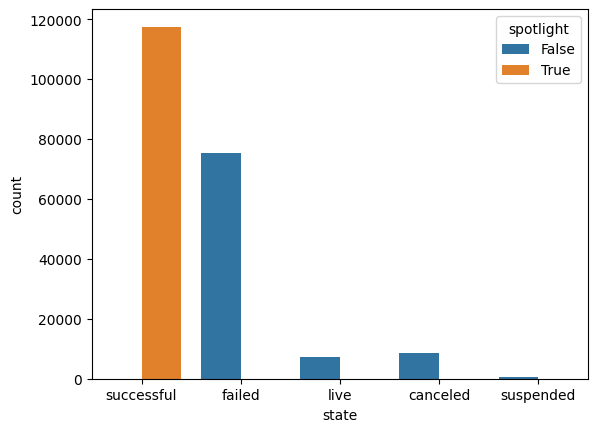

In [ ]:
sns.countplot(data=data, x='state', hue='spotlight')

In [ ]:
data.query('state=="live"')['state'].count()

7311